In [4]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
import matplotlib.pyplot as plt

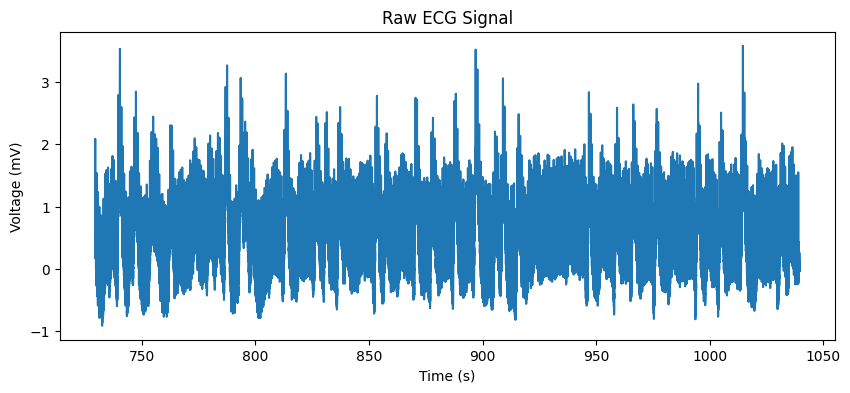

In [5]:
# load the ECG data from the CSV file
data = pd.read_csv('sam_ECG.csv')
time = data['time']
voltage = data['ecg']


# plot the raw ECG signal
plt.figure(figsize=(10, 4))
plt.plot(time, voltage)
plt.title("Raw ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()

In [6]:
# Digital notch filter to remove 50 Hz 
def notch_filter(signal, fs, freq=50.0, Q=30.0):
    b, a = iirnotch(freq / (fs / 2), Q)   # stores the filter coefficents
    y = filtfilt(b, a, signal)            # applying the filter to our signal
    return y

In [7]:
# IIR forward-backward filtering
def iir_bandpass_filter(signal, lowcut, highcut, fs, order=2):
    # normalising the lowcut freq and high cut freq by dividing them with half of sample frequency
    nyquist = 0.5 * fs  
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') # coefficent of filter
    y = filtfilt(b, a, signal) # applying the filter
    return y

In [8]:
# Sample rate can be inferred from the time array
fs = 1 / np.mean(np.diff(time))

# Apply notch filter
filtered_voltage = notch_filter(voltage, fs)

# Apply IIR forward-backward bandpass filter
filtered_voltage = iir_bandpass_filter(filtered_voltage, 8.0, 45.0, fs)


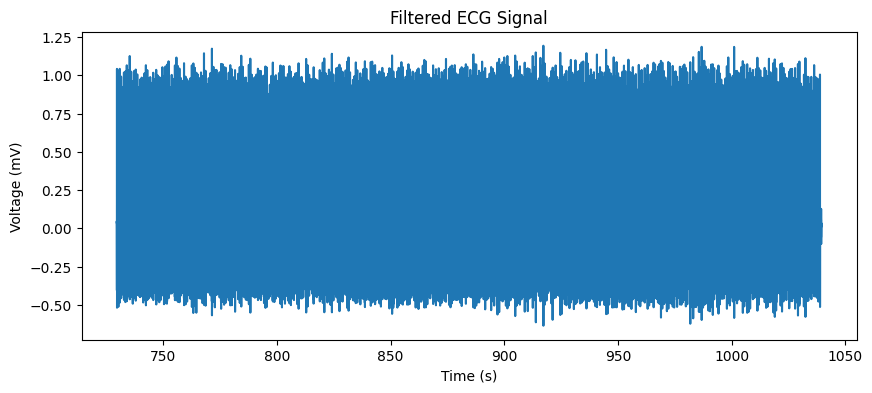

In [9]:
# Plot the filtered ECG signal
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_voltage)
plt.title("Filtered ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()

In [10]:
# R-peak detection using find_peaks with dynamic threshold
def detect_r_peaks(signal, fs):
    # Use the absolute value of the filtered signal for peak detection
    # so that both negative and postive peaks are considered 
    abs_signal = np.abs(signal)
    
    # Estimate a threshold as a percentage of the maximum absolute signal value
    # minimun value to be considered as peak
    threshold = 0.5 * np.max(abs_signal)
    
    # Detect peaks above the threshold
    peaks, _ = find_peaks(abs_signal, height=threshold, distance=int(fs*0.6))
    
    return peaks

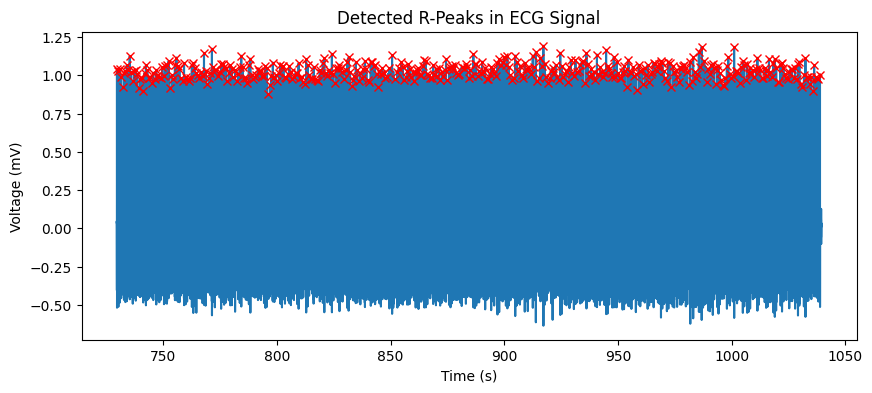

In [11]:
# Detect R-peaks
r_peaks = detect_r_peaks(filtered_voltage, fs)

# Plot detected R-peaks
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_voltage)
plt.plot(time[r_peaks], filtered_voltage[r_peaks], 'rx')  # Mark peaks with red 'x'
plt.title("Detected R-Peaks in ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()

In [12]:
# Calculate time intervals between consecutive peaks 
rr_intervals = np.diff(time[r_peaks])

# Convert R-R intervals to heart rate (BPM)
heart_rate = 60.0 / rr_intervals

# Calculate the mean heart rate
mean_heart_rate = np.mean(heart_rate)

print(f"Mean Heart Rate: {mean_heart_rate:.2f} BPM")

Mean Heart Rate: 90.75 BPM


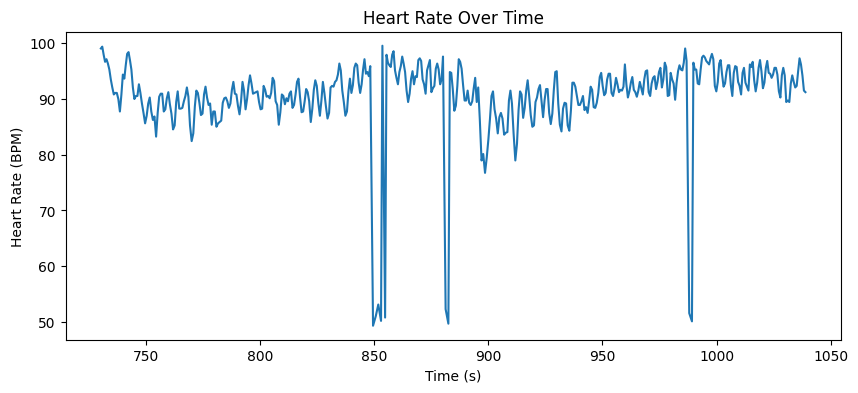

In [13]:
# Plot the heart rate over time
plt.figure(figsize=(10, 4))
plt.plot(time[r_peaks][1:], heart_rate)
plt.title("Heart Rate Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.show()
